# Dataset exploration
This notebook was used to generate tthe metadata corresponding to the dataset.

In [7]:
import os
import numpy as np
import pandas as pd
import re
import cv2

In [6]:
src = 'data/20201117-PMB-photos/'
por_mi_barrio_images = [fname.lower() for fname in os.listdir(src) if os.path.isfile(os.path.join(src, fname))]

src = 'data/20201117-PMB-photos/photo/'
por_mi_barrio_images += [fname.lower() for fname in os.listdir(src) if os.path.isfile(os.path.join(src, fname))]

por_mi_barrio_images = set(por_mi_barrio_images)

In [4]:
data_path = 'data/clean-dirty-garbage-containers/'
splits = ['train', 'test']
labels = ['clean', 'dirty']

In [63]:
df_im = pd.read_csv('data/Contenedores_domiciliarios.csv', sep=';')
df_im.head()

GID          COD_CIRCUITO  \
0  12321  C_DU_RM_CL_01          
1  12322  C_DU_RM_CL_01          
2  12327  C_DU_RM_CL_01          
3  12328  C_DU_RM_CL_01          
4  12332  C_DU_RM_CL_01          

                                       TURNO_HORARIO              X  \
0  DOMINGOS, MARTES Y JUEVES CON FERIADOS LABORAB...  572120.626113   
1  DOMINGOS, MARTES Y JUEVES CON FERIADOS LABORAB...  572142.846592   
2  DOMINGOS, MARTES Y JUEVES CON FERIADOS LABORAB...  572460.735330   
3  DOMINGOS, MARTES Y JUEVES CON FERIADOS LABORAB...  572444.012809   
4  DOMINGOS, MARTES Y JUEVES CON FERIADOS LABORAB...  571597.994874   

              Y  
0  6.141424e+06  
1  6.141390e+06  
2  6.141253e+06  
3  6.141398e+06  
4  6.140986e+06

In [64]:
df_im['X'][100]

573748.8680262737

In [67]:
def is_from_google(fname):
    
    match = re.search(r'^\d{5,6}_\d{2}\.jpg$', fname.strip())
    
    return int(match is not None)

def get_image_source(fname):
    res = 'other'
    if is_from_google(fname):
        res='GSV'
    elif fname.lower() in por_mi_barrio_images:
        res = 'por_mi_barrio'
    elif fname.lower().startswith('whats'):
        res = 'smartphone'
    return res

import utm

def get_lat_lon(x, y):
    return utm.to_latlon(x, y, 21, 'H')

def get_location(fname):
    
    match = re.search(r'^(\d{5,6})_\d{2}\.jpg$', fname.strip())
    x, y =  None, None
    if match:
        idx = int(match.group(1))
        x = df_im['X'][idx]
        y = df_im['Y'][idx]
        x, y = get_lat_lon(x, y)
    
    return x, y

In [69]:
dataset  = {
    'image_path': [],
    'annotation_path': [],
    'split': [],
    'label': [],
    'source': [],
    'x_lat': [],
    'y_lon': [],
    
}

for split in splits:
    for label in labels:
        folder = os.path.join(data_path, split, label)
        for fname in sorted(os.listdir(folder)):
            image_path = os.path.join('clean-dirty-garbage-containers', split, label, fname)
            
            
            ann_fname = re.sub(r'\.(jpe?g|png)$', '.xml', fname, flags=re.I)
            annotation_path = os.path.join(data_path, 'annotations', split, ann_fname)
            assert os.path.isfile(annotation_path), annotation_path
            
            dataset['image_path'].append(image_path)
            dataset['annotation_path'].append(os.path.join('clean-dirty-garbage-containers', 'annotations', split, ann_fname))
            dataset['label'].append(label)
            dataset['split'].append(split)
            dataset['source'].append(get_image_source(fname))
            x, y = get_location(fname)
            dataset['x_lat'].append(x)
            dataset['y_lon'].append(y)

df = pd.DataFrame(dataset)

In [70]:
df.head()

image_path  \
0  clean-dirty-garbage-containers/train/clean/001...   
1  clean-dirty-garbage-containers/train/clean/001...   
2  clean-dirty-garbage-containers/train/clean/001...   
3  clean-dirty-garbage-containers/train/clean/001...   
4  clean-dirty-garbage-containers/train/clean/001...   

                                     annotation_path  split  label source  \
0  clean-dirty-garbage-containers/annotations/tra...  train  clean    GSV   
1  clean-dirty-garbage-containers/annotations/tra...  train  clean    GSV   
2  clean-dirty-garbage-containers/annotations/tra...  train  clean    GSV   
3  clean-dirty-garbage-containers/annotations/tra...  train  clean    GSV   
4  clean-dirty-garbage-containers/annotations/tra...  train  clean    GSV   

       x_lat      y_lon  
0 -34.883318 -56.183366  
1 -34.887446 -56.169529  
2 -34.887011 -56.169587  
3 -34.884381 -56.169892  
4 -34.888235 -56.176966

In [74]:
df.to_csv('metadata.csv', index=False, sep=';')

In [81]:
df.columns

Index(['image_path', 'annotation_path', 'split', 'label', 'source', 'x_lat',
       'y_lon'],
      dtype='object')

In [60]:

def show_random_samples(source, n_max):
    n_rows = 5
    n_cols = 5
    n = n_rows * n_cols

    idx =  np.random.choice(n_max, n)

    plt.figure(figsize=(15,15))

    for i, f in enumerate(df[df['source']==source]['image_path'].values[idx]):
        img = cv2.imread(os.path.join('data', f))[...,::-1]

        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(f))
        plt.xticks([])
        plt.yticks([])


In [39]:
unq, cnt = np.unique(df['source'], return_counts=True)
for u, c in zip(unq, cnt):
    print(u, c, c/cnt.sum())

GSV 493 0.1444900351699883
other 234 0.06858147713950762
por_mi_barrio 378 0.11078546307151231
smartphone 2307 0.6761430246189918


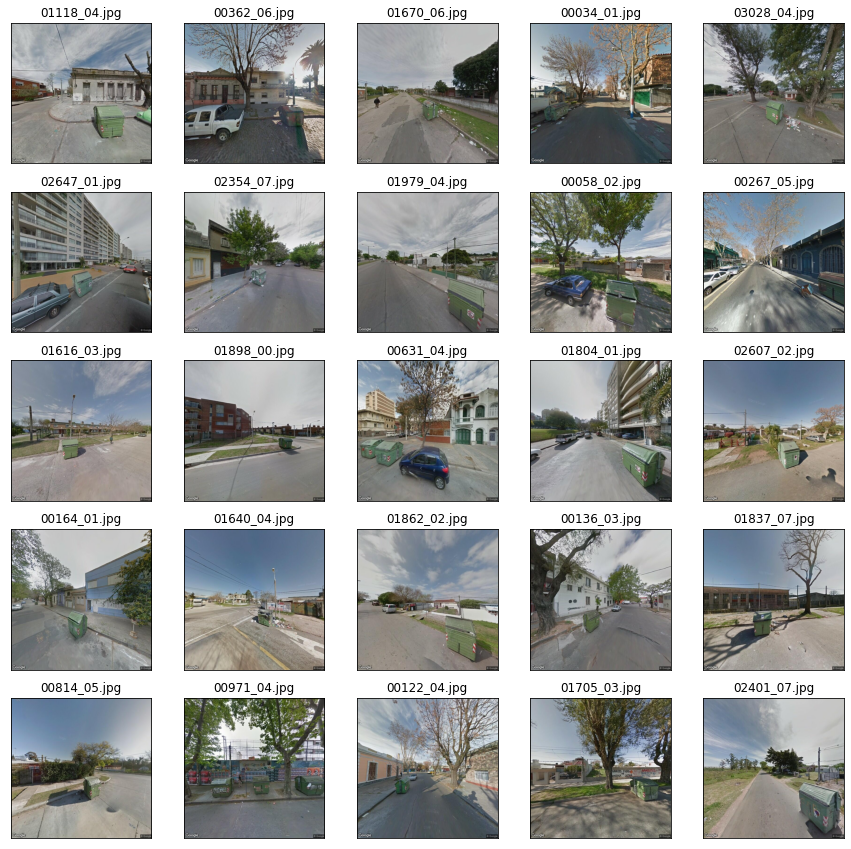

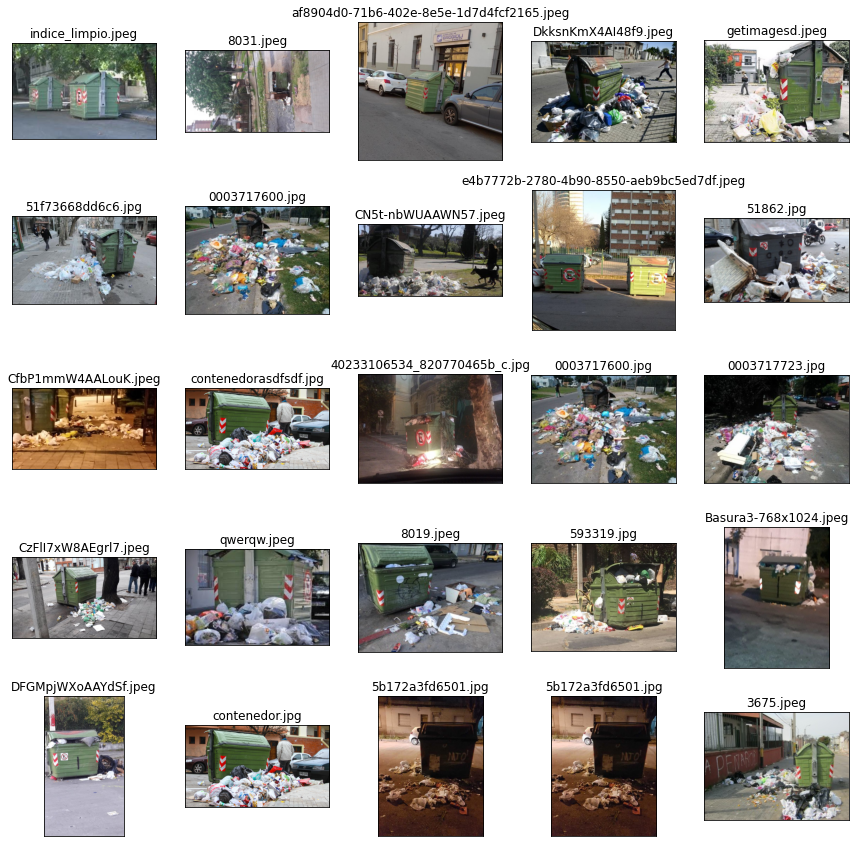

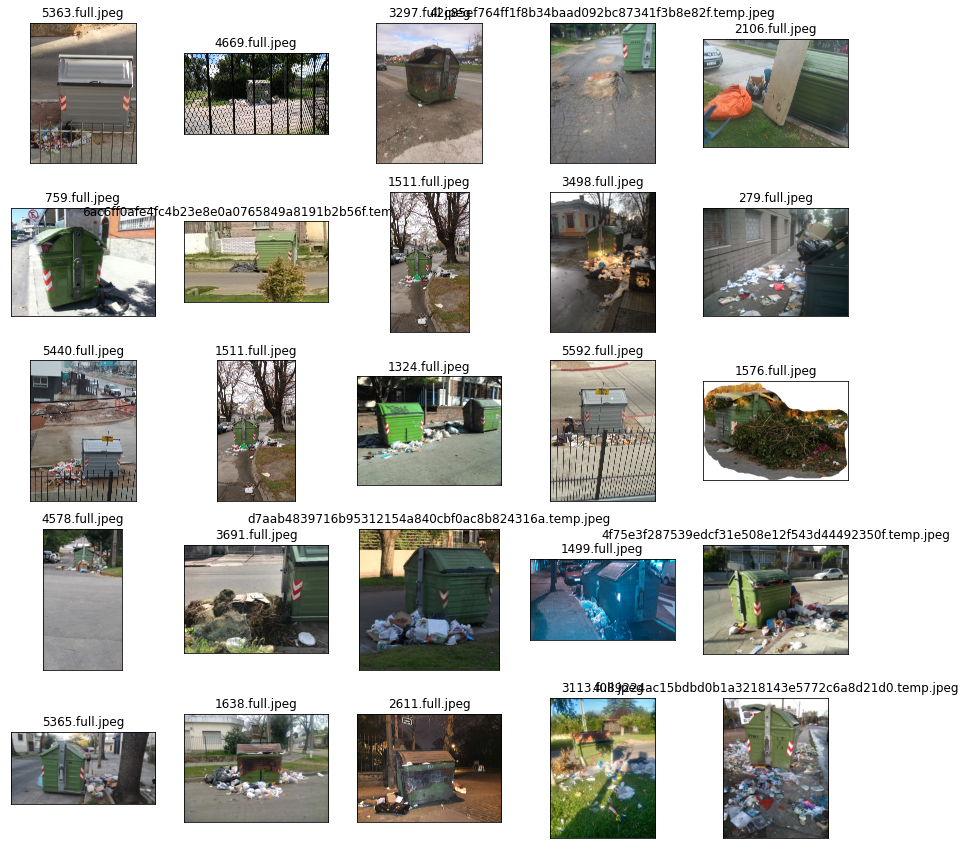

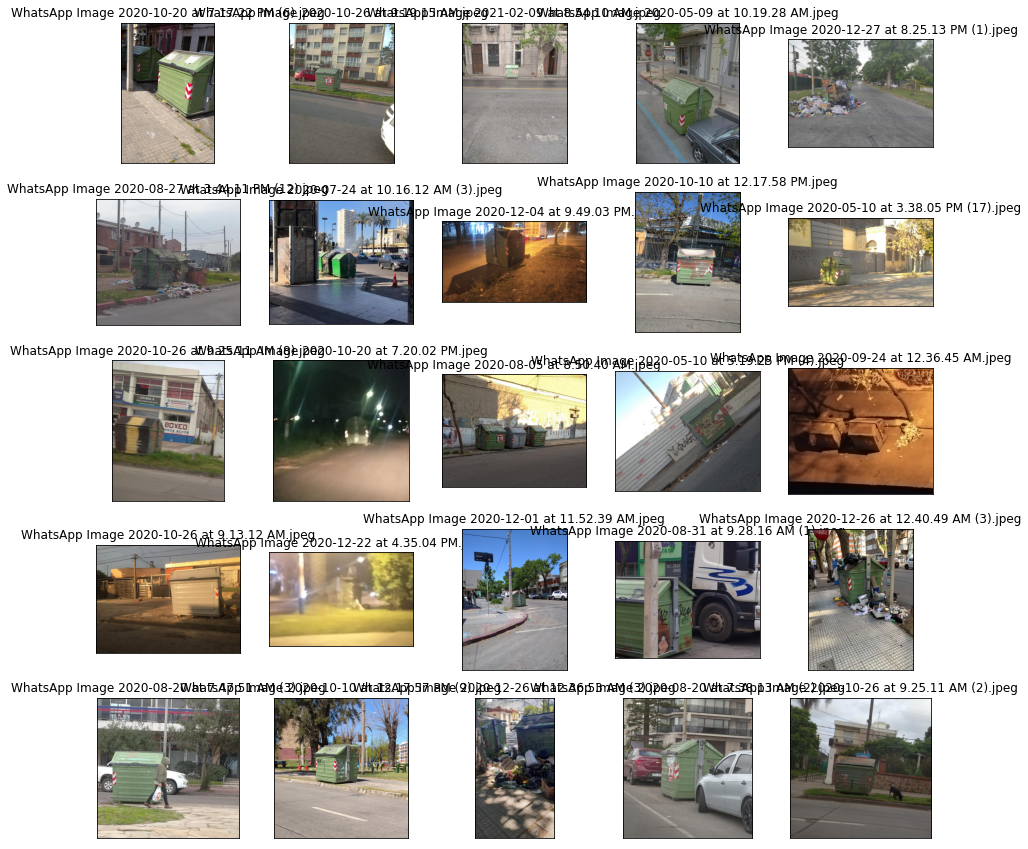

In [61]:
for u, c in zip(unq, cnt):
    show_random_samples(u, c)

In [45]:
plt.subplots?

In [33]:
import cv2
import matplotlib.pylab as plt